In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join('..'))

from counting_boats.utils.image_cutting_support import latlong2coord

DETECTION_CSV   = '../results/boat_detections.csv'
COVERAGE_CSV    = '../results/coverage.csv'
UDM_DIR         = '../results/UDM'
GRID_SIZE       = 1000 # Meters

# Plots

## Density Plots
- Count/Time seen for each grid cell
    - Aggregate years
    - Aggregate months
    - Aggregate Days of weeks (or weekend/weekday)

- Moving vs Static Boats density (3D spatial plots)
    - Aggregate years
    - Aggregate months
    - Aggregate Days of weeks (or weekend/weekday)

## Numerical Plots
- Data availability over time
    - % of AOI per day over time
    - Raw counts over time (limited to >90% AOI coverage)
    - Any imputations



In [78]:
# Detections are in the form of latitude, longitude, and date for each detection.
# We can get the extent of the detections by finding the min and max of lat/lons.
# Need to convert lat long into an EPSG projection in meters.
# Then use the extent to define the grid.
# Assign each detection to a grid cell (gridx, gridy) for further analysis

all_detections = pd.read_csv(DETECTION_CSV)
all_detections["date"] = pd.to_datetime(all_detections["date"], dayfirst=True)
# convert lat long to meters (x, y)
# we have to do this point by point because the conversion is not vectorized
all_detections['x'], all_detections['y'] = zip(*all_detections.apply(lambda row: latlong2coord(row['longitude'], row['latitude']), axis=1))


# get the extent of the detections
minx, miny, maxx, maxy = all_detections['x'].min(), all_detections['y'].min(), all_detections['x'].max(), all_detections['y'].max()
# define the grid as the extent +- 1 grid size
grid_minx, grid_miny = minx - GRID_SIZE, miny - GRID_SIZE
grid_maxx, grid_maxy = maxx + GRID_SIZE, maxy + GRID_SIZE

def point_to_grid(x, y):
    """Given a point in meters, return the grid cell it belongs to."""
    gridx = int((x - grid_minx) // GRID_SIZE)
    gridy = int((y - grid_miny) // GRID_SIZE)
    return gridx, gridy

# assign each detection to a grid cell
all_detections['gridx'], all_detections['gridy'] = zip(*all_detections.apply(lambda row: point_to_grid(row['x'], row['y']), axis=1))

In [79]:
from counting_boats.utils.area_coverage import use_udm_2
import rasterio

def udm_clear(udm_name):
    """
    Load the UDM clear band for an image
    
    Return: a numpy array of the UDM clear band, the minx, miny, maxx, maxy of the image
    """
    path = os.path.join(UDM_DIR, udm_name)
    # open the mask
    udm = rasterio.open(path)
    # Check if UDM1 or UDM2.1
    if not use_udm_2(path):
        # In band 8: bit 0 is not imaged, bit 1 is cloud. So we want to return 1 for any pixels in the mask that don't have either of those bits set.
        mask = udm.read(8) & 0b11 == 0
    else:
        # UDM2 has a clear band we can return directly
        mask = udm.read(1)

    # get the extent of the image
    minx, miny, maxx, maxy = udm.bounds
    return mask, minx, miny, maxx, maxy


## Count/Time seen for each grid cell

In [80]:
# Group detections by year, and then count by grid cell
all_detections['year'] = all_detections['date'].dt.year

year_grouped = all_detections.groupby('year')
print(year_grouped.head())
# aggregate detections by grid cell to have e.g: 2016 grid cell 0, 0 has 1 . . . 2016 grid cell 1, 0 has 2
detections_by_year = year_grouped.apply(lambda x: x.groupby(['gridx', 'gridy']).size().reset_index(name='counts'))
# print

# now we need to generate a coverage heatmap for each year (e.g same grid size, but now number of images taken of each grid cell)
heatmaps = {}
# for each udm add its clear band to the heatmap for that year
for udm in os.listdir(UDM_DIR):
    year = int(udm.split('_')[1][:4])
    if year not in heatmaps:
        heatmaps[year] = {}
    mask, minx, miny, maxx, maxy = udm_clear(udm)
    # if more than 50% of a grid cell is covered by the image, we consider it covered
    # The mask will not cover the whole area of the grid so we can just consider the covered area
    gridx1, gridy1 = point_to_grid(minx, miny)
    gridx2, gridy2= point_to_grid(maxx, maxy)
    # iterate over the grid cells covered by the image
    UDM_PIXEL_SIZE = 3 # meter resolution of udm
    for x in range(gridx1, gridx2 + 1):
        for y in range(gridy1, gridy2 + 1):
            if x < 0 or y < 0:
                # Might be imaged but no boats ever found here. Just ignore
                continue
            x1, y1 = x * GRID_SIZE + grid_minx, y * GRID_SIZE + grid_miny
            # get the area of the grid cell that is covered by the mask
            x2, y2 = x1 + GRID_SIZE, y1 + GRID_SIZE
            # in mask coordinates
            mask_x1 = int((x1 - minx) // UDM_PIXEL_SIZE)
            mask_y1 = int((y1 - miny) // UDM_PIXEL_SIZE)
            mask_x2 = int((x2 - minx) // UDM_PIXEL_SIZE)
            mask_y2 = int((y2 - miny) // UDM_PIXEL_SIZE)
            # sum of mask within these bounds
            coverage = mask[mask_y1:mask_y2, mask_x1:mask_x2].sum()
            # if more than 50% of the grid cell is covered, we consider it covered
            if coverage > 0.5 * (GRID_SIZE/UDM_PIXEL_SIZE) ** 2:
                heatmaps[year][(x, y)] = 1




        date  class                images   latitude   longitude  confidence  \
0 2016-11-05      0  20161105_moreton.tif -27.426439  153.287434    0.684667   
1 2016-11-05      0  20161105_moreton.tif -27.388937  153.268858    0.816644   
2 2016-11-05      0  20161105_moreton.tif -27.267352  153.333305    0.807534   
3 2016-11-05      0  20161105_moreton.tif -27.324935  153.354917    0.901631   
4 2016-11-05      0  20161105_moreton.tif -27.076459  153.365901    0.867336   

          w         h      aoi         x          y  gridx  gridy  year  
0  2.875000  2.875000  moreton  528409.5  6966298.5     20     13  2016  
1  3.999998  4.083331  moreton  526582.5  6970456.5     18     17  2016  
2  4.124997  4.124996  moreton  532990.5  6983908.5     25     31  2016  
3  6.187506  6.062508  moreton  535111.5  6977524.5     27     24  2016  
4  3.687499  3.000001  moreton  536278.5  7005043.5     28     52  2016  


C:\Users\turner30\AppData\Local\Temp\ipykernel_13316\1601214219.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  detections_by_year = year_grouped.apply(lambda x: x.groupby(['gridx', 'gridy']).size().reset_index(name='counts'))


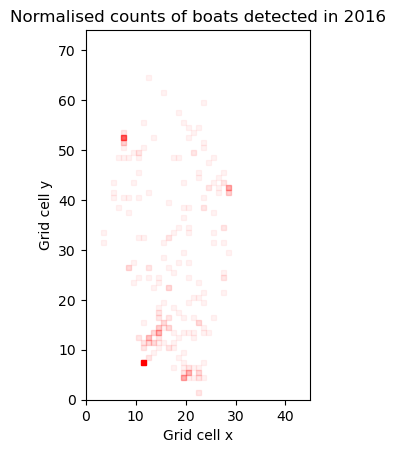

Total detections in 2016: 271.0


In [81]:
# Now, normalise the counts by the coverage. E.g if a grid cell has 2 detections and 3 images, the normalised count is 2/3
normalised_counts = {}
for gridx in range(grid_maxx)




# Now we can plot the normalised counts
for year, counts in normalised_counts.items():
    fig, ax = plt.subplots()
    ax.set_title(f'Normalised counts of boats detected in {year}')
    ax.set_xlabel('Grid cell x')
    ax.set_ylabel('Grid cell y')
    ax.set_aspect('equal')
    total = 0
    max_count = max(counts.values())
    for (gridx, gridy), count in counts.items():
        if count > 0:
            total += count
            # plot a square at the grid cell
            ax.add_patch(plt.Rectangle((gridx, gridy), 1, 1, fill=True, color='red', alpha=(count / max_count)))
    # scale plot to fit everything
    ax.set_xlim(0, max(counts.keys(), key=lambda x: x[0])[0] + 10)
    ax.set_ylim(0, max(counts.keys(), key=lambda x: x[1])[1] + 10)
    plt.show()
    print(f'Total detections in {year}: {total}')

507777.4999999989 6952560.5 543905.5000000005 7018076.5
153.07877760346855 -27.550738800336436 153.44236341112136 -26.95857143261586
http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=153.07877760346855,-27.550738800336436,153.44236341112136,-26.95857143261586&bboxSR=4326&imageSR=4326&size=1000,1628&dpi=96&format=png32&transparent=true&f=image
0.010101125623151574 0.009034943604536494
0.010102749429819369 0.009035645786866553
0.010099488386089206 0.009035680918380251
0.010098674077511305 0.009035689695931381
0.01009786014961378 0.009035698471343778
0.010093787996396486 0.009036459839077082
0.010092165088565253 0.00903647680549824
0.010084862114723592 0.00903798280643997
0.01008405464742168 0.009037990711764365
0.010082440847725138 0.009038006516359331
0.010085659478789921 0.009038690469203914
0.01007759807211528 0.00903876667367598
0.010083225853179556 0.009039428363465163
0.010076782804986806 0.009039487073380315
0.010075175816893989 0.009039

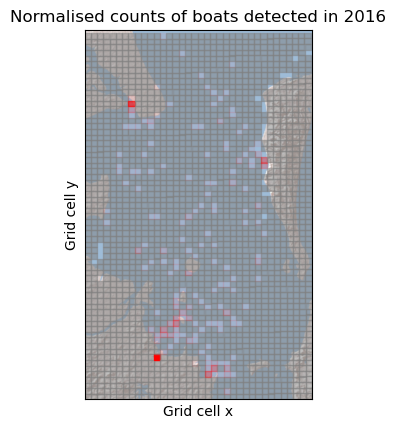

Total detections in 2016: 271.0


In [123]:
from mpl_toolkits.basemap import Basemap
from counting_boats.utils.image_cutting_support import coord2latlong

# exact same plot as above, but with basemap background
for year, counts in normalised_counts.items():
    fig, ax = plt.subplots()
    ax.set_title(f'Normalised counts of boats detected in {year}')
    ax.set_xlabel('Grid cell x')
    ax.set_ylabel('Grid cell y')
    ax.set_aspect('equal')
    total = 0
    max_count = max(counts.values())
    print(grid_minx, grid_miny, grid_maxx, grid_maxy)
    minlon, minlat = coord2latlong(grid_minx, grid_miny)
    maxlon, maxlat = coord2latlong(grid_maxx, grid_maxy)
    print(minlon, minlat, maxlon, maxlat)
    m = Basemap(llcrnrlon=minlon, llcrnrlat=minlat, urcrnrlon=maxlon, urcrnrlat=maxlat, epsg=4326)

    m.arcgisimage(service='World_Shaded_Relief', xpixels=1000, verbose=True)

    gridx_range = max(counts.keys(), key=lambda x: x[0])[0] + 1
    gridy_range = max(counts.keys(), key=lambda x: x[1])[1] + 1
    combinations = [(x, y) for x in range(gridx_range) for y in range(gridy_range)]
    for (gridx, gridy) in combinations:
        count = counts.get((gridx, gridy), None)
        if count is not None:
            total += count
            # plot a square at the grid cell
            # have to convert grid cell to lat long
            x, y = gridx * GRID_SIZE + grid_minx, gridy * GRID_SIZE + grid_miny
            lon, lat = coord2latlong(x, y)
            grid_size_lon, grid_size_lat = coord2latlong(x + GRID_SIZE, y+ GRID_SIZE)
            w = abs(lon - grid_size_lon)
            h = abs(lat - grid_size_lat)
            x, y = m(lon, lat)
            # plot the square
            ax.add_patch(plt.Rectangle((x, y), w, h, fill=True, color='red', alpha=(count / max_count)))
        else:
            # plot a grey square to indicate no capture at all
            x, y = gridx * GRID_SIZE + grid_minx, gridy * GRID_SIZE + grid_miny
            lon, lat = coord2latlong(x, y)
            grid_size_lon, grid_size_lat = coord2latlong(x + GRID_SIZE, y+ GRID_SIZE)
            w = abs(lon - grid_size_lon)
            h = abs(lat - grid_size_lat)
            x, y = m(lon, lat)
            ax.add_patch(plt.Rectangle((x, y), w, h, fill=True, color='grey', alpha=0.5))
    plt.show()
    print(f'Total detections in {year}: {total}')